In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
def myseq_with_plotting(path:str,grayLevels = 256):
    img = Image.open(path).convert('L')
    H,W = img.size
    size = H*W
    occurrencies = [0.0 for _ in range(grayLevels)]
    pixels_flattened = np.array(img).flatten()
    for pixel in pixels_flattened:
        occurrencies[pixel]+=1
    cdf = [sum(occurrencies[:i+1]) for i in range(grayLevels)]
    cdfmin = next((x for x in cdf if x),-1)
    h = [round((cdf[v]-cdfmin)/(size-cdfmin) * (grayLevels-1)) for v in range(grayLevels)]

    for id,pixel in enumerate(pixels_flattened):
        pixels_flattened[id] = h[pixel]

    occurrencies_equalized = [0.0 for _ in range(grayLevels)]
    for pixel in pixels_flattened:
        occurrencies_equalized[pixel]+=1

    reshaped_image = np.reshape(pixels_flattened,(W,H))
    
    plt.bar(range(grayLevels),occurrencies_equalized,label = 'equalized')
    plt.bar(range(grayLevels),occurrencies,label = 'original')
    plt.legend()
    return Image.fromarray(reshaped_image)
myseq_with_plotting('baby.png')


In [ ]:
def sequential(path:str,grayLevels = 256) -> np.ndarray:
    img = Image.open(path).convert('L')
    H,W = img.size
    size = H*W
    occurencies = [0.0 for _ in range(grayLevels)]
    pixels_flattened = np.array(img).flatten()
    for pixel in pixels_flattened:
        occurencies[pixel]+=1
    cdf = [int(sum(occurencies[:i+1])) for i in range(grayLevels)]
    cdfmin = next((x for x in cdf if x),-1)

    h = [round((cdf[v]-cdfmin)/(size-cdfmin) * (grayLevels-1)) for v in range(grayLevels)]
    for id,pixel in enumerate(pixels_flattened):
        pixels_flattened[id] = h[pixel]
    return np.reshape(pixels_flattened,(W,H))
    


In [100]:
%%time
sequ = sequential('baby.png')


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 8, 11, 19, 23, 29, 37, 49, 66, 81, 101, 129, 141, 167, 180, 204, 232, 250, 271, 299, 318, 348, 371, 400, 431, 467, 499, 525, 568, 600, 628, 674, 716, 764, 807, 845, 872, 934, 986, 1040, 1106, 1156, 1198, 1259, 1323, 1387, 1440, 1495, 1566, 1624, 1693, 1753, 1805, 1874, 1946, 2029, 2107, 2184, 2272, 2360, 2460, 2577, 2708, 2855, 2985, 3193, 3433, 3694, 4073, 4615, 5345, 6323, 7386, 8512, 9615, 10678, 11749, 12692, 13652, 14654, 15749, 16982, 18313, 19873, 21320, 22694, 24068, 25365, 26633, 27935, 29350, 30862, 32367, 33839, 35254, 36590, 37959, 39468, 41038, 42691, 44308, 45835, 47342, 48866, 50294, 51430, 52308, 52965, 53542, 54037, 54516, 54940, 55359, 55762, 56127, 56473, 56768, 57060, 57397, 57672, 57950, 58254, 58563, 58859, 59183, 59506, 59807, 60158, 60524, 60915, 61343, 61839, 62346, 62883, 63509, 64166, 64906, 65691, 66534, 67468, 68463, 69434, 70437, 71303, 72136, 72915, 7

In [ ]:
import numba as  nb
import numpy as np
from numba import cuda

@cuda.jit
def countOccurencies(pixelsMatrix,occurencies):
    x,y = cuda.grid(2)
    if x>=pixelsMatrix.shape[0] or y>=pixelsMatrix.shape[1]:
        return
    cuda.atomic.add(occurencies,pixelsMatrix[x][y],1)

@cuda.jit
def calcCDF(occurencies_d,cdf):
    acc = 0
    for i in range(cuda.grid(1)+1):
        acc+=occurencies_d[i]
    cdf[cuda.grid(1)] = acc

@cuda.jit
def calcH(h,cdf_d,cdfmin_d,size_d,grayLevels_d):
    nominator = (cdf_d[cuda.grid(1)]-nb.int32(cdfmin_d))

    denominator = (size_d-cdfmin_d)
    multiplier = (grayLevels_d-1)
    result = round(nominator/denominator*multiplier)

    h[cuda.grid(1)] = result
    # print("XD")

@cuda.jit
def changeOriginalValues(h_d,pixelsMatrix):
    x,y = cuda.grid(2)
    if x>=pixelsMatrix.shape[0] or y>=pixelsMatrix.shape[1]:
        return
    pixelsMatrix[x][y] = nb.int32( h_d[pixelsMatrix[x][y]] )





def parallel(pixelsMatrix,grayLevels = 256):
    H,W = pixelsMatrix.shape
    blockdim = (32, 32)

    griddim = (H // blockdim[0] + 1,W // blockdim[1] + 1)
    occurencies = np.zeros(grayLevels,np.int32)
    pixelsMatrix = pixelsMatrix.astype(np.int32)
    pixelsMatrix_d = cuda.to_device(pixelsMatrix)
    occurencies_d = cuda.to_device(occurencies)
    countOccurencies[griddim,blockdim](pixelsMatrix_d,occurencies_d)
    cdf = np.zeros(grayLevels,np.int32)
    cdf_d = cuda.to_device(cdf)
    threadsperblock = 32
    blockspergrid = (grayLevels + (threadsperblock - 1)) // threadsperblock
    calcCDF[threadsperblock,blockspergrid](occurencies_d,cdf_d)

    del occurencies_d

    cdfmin = next((x for x in cdf_d if x),-1)

    h = np.zeros(grayLevels,np.int32)
    h_d = cuda.to_device(h)
    

    cuda.synchronize()
    calcH[threadsperblock,blockspergrid](h_d,cdf_d,nb.int32(cdfmin),nb.int32(H*W),nb.int32(grayLevels))
    del cdfmin
    del cdf_d
    changeOriginalValues[griddim,blockdim](h_d,pixelsMatrix_d)
    
    del h_d


    return pixelsMatrix_d

    
    


img = Image.open('baby.png').convert('L')
pixelsMatrix = np.array(img)




In [ ]:
%%time 
xd = parallel(pixelsMatrix)

[104 104  94  90 104  99  90  86  86  86  90  82  90  73  77  69  73  69
  69  69  64  69  64  69  69  59  64  55  55  55  51  34  38  38  38  34
  31  27  31  24  31  31  31  27  31  34  20  24  20  24  20  15  15  15
  17  15  15  12  15  20  17  17  15  20  17  20  20  24  20  24  17  20
  17  20  15  15  17  20  12  17  31  20  24  17  15  27  20  17  20  20
  20  15  17  20  24  20  24  20  24  17  17  24  17  27  24  27  20  17
  24  15  17  20  15  17  20  20  17  15  24  20  20  17  20  17  13  20
  15  17  12  13  13  13  17  13  20  15  13  17  15  17  13  15  13  15
  15  20  20  17  15  15  24  13  17  17  17  13  20  15  15  13  20  24
  20  20  20  20  20  27  31  27  27  31  31  27  27  20  24  20  24  31
  24  20  17  20  20  24  27  27  24  20  20  20  31  24  24  27  20  24
  24  27  20  31  24  20  20  20  31  24  24  34  31  34  31  27  27  24
  27  38  31  34  31  31  41  41  41  55  51  47  44  41  38  44  44  55
  44  55  59  55  51  55  59  59  55  59  59  59  6

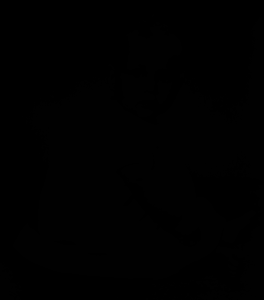